In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
tf.config.list_physical_devices('GPU')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

In [3]:
df = pd.read_parquet('clean_data.pqt')

In [4]:
X= df['comment_text']
y= df.drop(['id','comment_text'], axis=1)
print(y)

X_train, X_valid, ytrain, yvalid = train_test_split(X,y,test_size=.3, random_state=77)
print(X_train.shape[0])
print(X_valid.shape[0]) 

        toxic  severe_toxic  obscene  threat  insult  identity_hate
0           0             0        0       0       0              0
1           0             0        0       0       0              0
2           0             0        0       0       0              0
3           0             0        0       0       0              0
4           0             0        0       0       0              0
...       ...           ...      ...     ...     ...            ...
159566      0             0        0       0       0              0
159567      0             0        0       0       0              0
159568      0             0        0       0       0              0
159569      0             0        0       0       0              0
159570      0             0        0       0       0              0

[159571 rows x 6 columns]
111699
47872


In [5]:
MAX_VOCAB_SIZE = 200000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid = tokenizer.texts_to_sequences(X_valid)

In [6]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(V)

150507


In [7]:
data_train = pad_sequences(sequences_train)
print(data_train.shape)
T= data_train.shape[1]
data_valid = pad_sequences(sequences_valid, maxlen=T)
print(data_valid.shape)

(111699, 1250)
(47872, 1250)


In [8]:
X_train.to_pickle('data_train.pkl')
X_valid.to_pickle('data_valid.pkl')
ytrain.to_pickle('ytrain.pkl')
yvalid.to_pickle('yvalid.pkl')

In [9]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model= Model(i,x)

In [10]:
def history_plots(redux, metric):
    valid = "val_"+metric
    plt.plot(redux.history[metric], label=metric)
    plt.plot(redux.history[valid], label=valid)
    plt.legend()
    plt.show()

In [11]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

r = model.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 74s 61ms/step - loss: 515543968.0000 - accuracy: 0.2679 - precision: 0.0471 - recall: 0.2082 - val_loss: 5003132416.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0100 - val_recall: 0.0453
Epoch 2/25
1117/1117 [==============================] - 68s 61ms/step - loss: 23636015104.0000 - accuracy: 0.2485 - precision: 0.0463 - recall: 0.2106 - val_loss: 92690866176.0000 - val_accuracy: 0.0031 - val_precision: 0.0530 - val_recall: 0.2406
Epoch 3/25
1117/1117 [==============================] - 68s 61ms/step - loss: 154299088896.0000 - accuracy: 0.2487 - precision: 0.0464 - recall: 0.2112 - val_loss: 311335256064.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0100 - val_recall: 0.0453
Epoch 4/25
1117/1117 [==============================] - 70s 62ms/step - loss: 535743070208.0000 - accuracy: 0.2487 - precision: 0.0461 - recall: 0.2098 - val_loss: 717221593088.0000 - val_accuracy: 0.0021 - val_precision: 0.0490 - val_recall: 0.2229

In [12]:
def f1_derive(hist=r,prc='precision',rcl='recall'):
    vp= 'val_'+prc
    v_re= 'val_'+rcl
    CH_hist= pd.DataFrame(hist.history)
    CH_hist['f1'] =(2*CH_hist[prc]*CH_hist[rcl])/(CH_hist[prc]+CH_hist[rcl])
    CH_hist['val_f1'] =(2*CH_hist[vp]*CH_hist[vp])/(CH_hist[vp]+CH_hist[vp])
    CH_hist.fillna(0,inplace=True)

    plt.plot(CH_hist['f1'], label='f1')
    plt.plot(CH_hist['val_f1'], label='val_f1')
    plt.legend()
    plt.show()

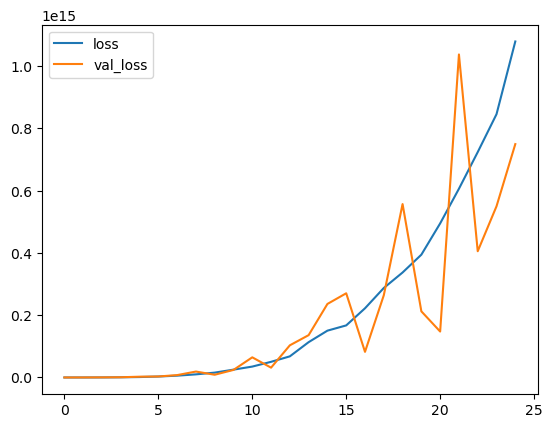

In [13]:
history_plots(r,'loss')

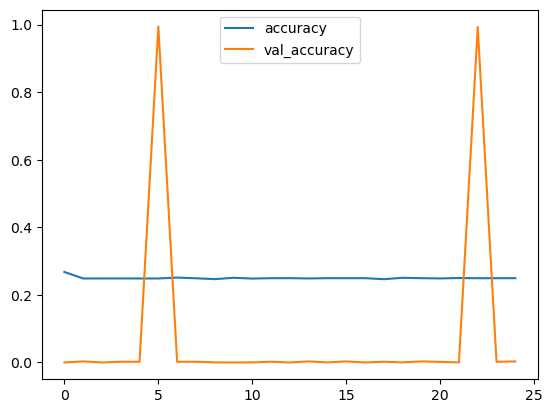

In [14]:
history_plots(r,'accuracy')

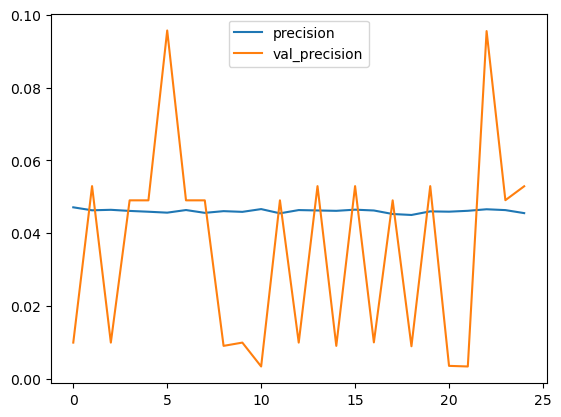

In [15]:
history_plots(r,'precision')

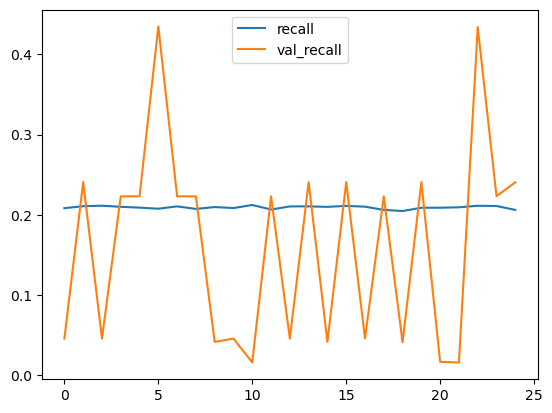

In [16]:
history_plots(r,'recall')

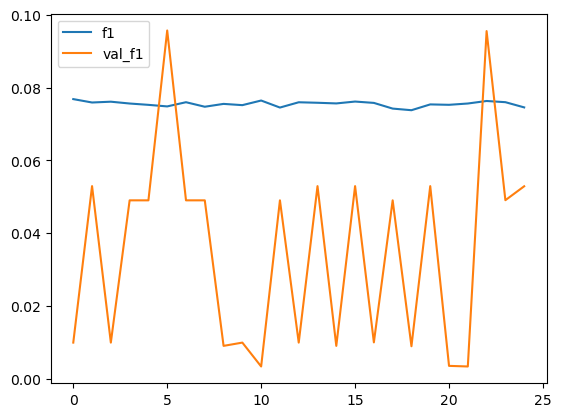

In [17]:
f1_derive(r,'precision','recall')

In [18]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model2= Model(i,x)

In [19]:
model2.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

q = model2.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 44s 39ms/step - loss: 305348.5938 - accuracy: 0.2713 - precision: 0.0469 - recall: 0.2007 - val_loss: 1158381.0000 - val_accuracy: 0.0021 - val_precision: 0.0490 - val_recall: 0.2229
Epoch 2/25
1117/1117 [==============================] - 44s 39ms/step - loss: 6657110.5000 - accuracy: 0.2474 - precision: 0.0463 - recall: 0.2106 - val_loss: 18656352.0000 - val_accuracy: 2.7156e-04 - val_precision: 0.0090 - val_recall: 0.0407
Epoch 3/25
1117/1117 [==============================] - 44s 39ms/step - loss: 35290048.0000 - accuracy: 0.2489 - precision: 0.0469 - recall: 0.2131 - val_loss: 65132036.0000 - val_accuracy: 0.9943 - val_precision: 0.0957 - val_recall: 0.4350
Epoch 4/25
1117/1117 [==============================] - 43s 39ms/step - loss: 102730448.0000 - accuracy: 0.2486 - precision: 0.0458 - recall: 0.2081 - val_loss: 50207760.0000 - val_accuracy: 0.9943 - val_precision: 0.0957 - val_recall: 0.4350
Epoch 5/25
1117/1117 [=========

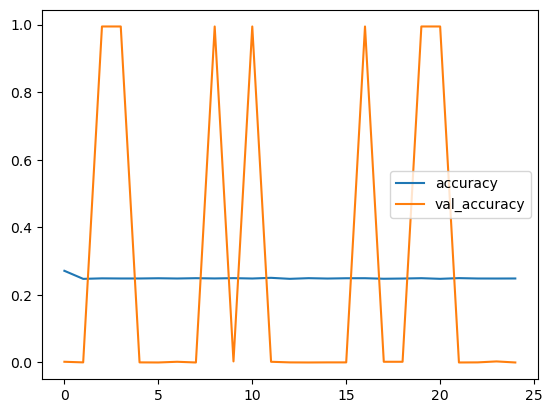

In [20]:
history_plots(q,'accuracy')

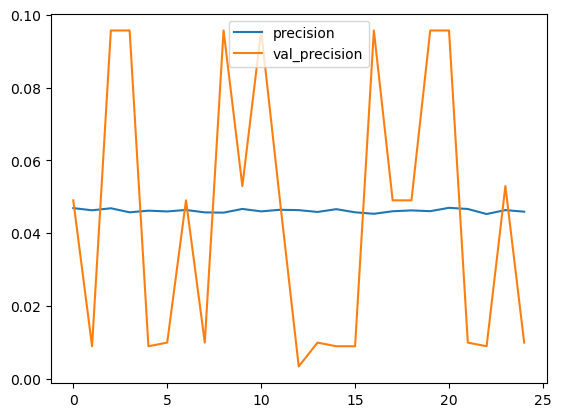

In [21]:
history_plots(q,'precision')

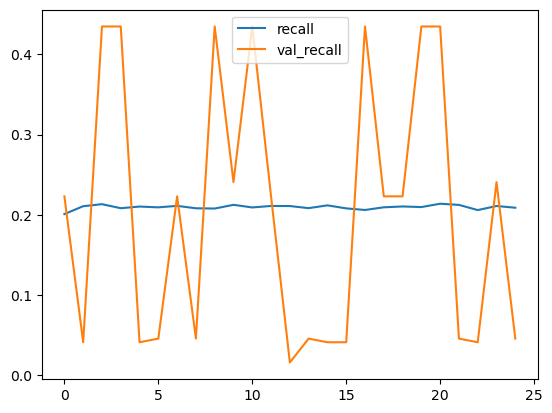

In [22]:
history_plots(q,'recall')

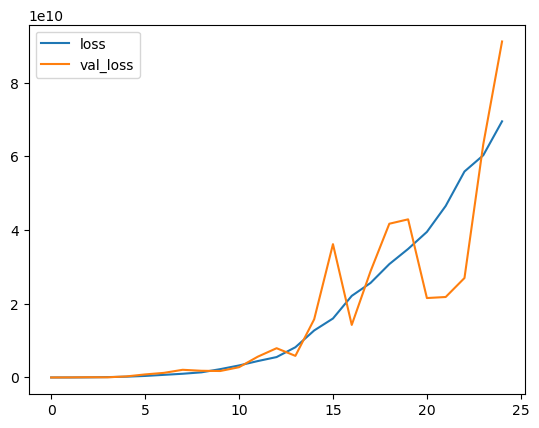

In [23]:
history_plots(q,'loss')

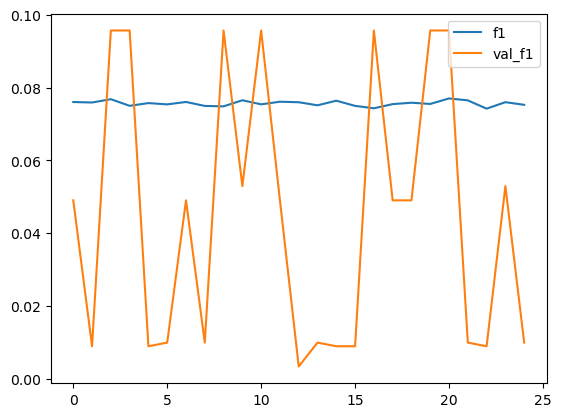

In [24]:
f1_derive(q,'precision','recall')

In [25]:
D=60
m=64
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model3= Model(i,x)

In [26]:
model3.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

s = model3.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 134s 119ms/step - loss: 10163036160.0000 - accuracy: 0.2570 - precision: 0.0466 - recall: 0.2080 - val_loss: 132167294976.0000 - val_accuracy: 2.7156e-04 - val_precision: 0.0090 - val_recall: 0.0407
Epoch 2/25
1117/1117 [==============================] - 134s 120ms/step - loss: 406072426496.0000 - accuracy: 0.2476 - precision: 0.0466 - recall: 0.2119 - val_loss: 1058335883264.0000 - val_accuracy: 2.5067e-04 - val_precision: 0.0034 - val_recall: 0.0155
Epoch 3/25
1117/1117 [==============================] - 133s 119ms/step - loss: 2978051260416.0000 - accuracy: 0.2490 - precision: 0.0457 - recall: 0.2078 - val_loss: 5045341913088.0000 - val_accuracy: 0.0021 - val_precision: 0.0490 - val_recall: 0.2229
Epoch 4/25
1117/1117 [==============================] - 133s 119ms/step - loss: 9947852046336.0000 - accuracy: 0.2495 - precision: 0.0457 - recall: 0.2076 - val_loss: 13080995037184.0000 - val_accuracy: 2.7156e-04 - val_precision: 0.0

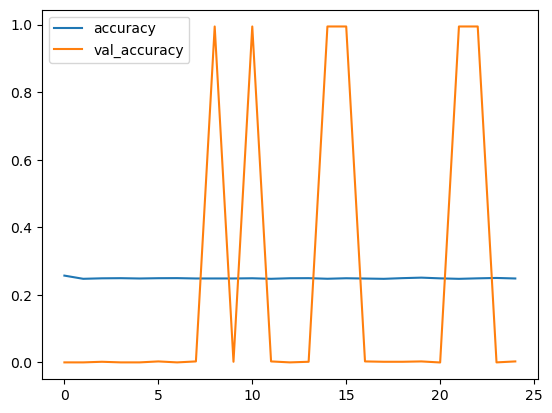

In [27]:
history_plots(s,'accuracy')

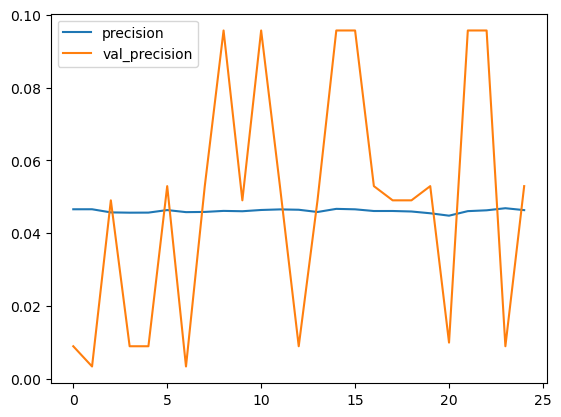

In [28]:
history_plots(s,'precision')

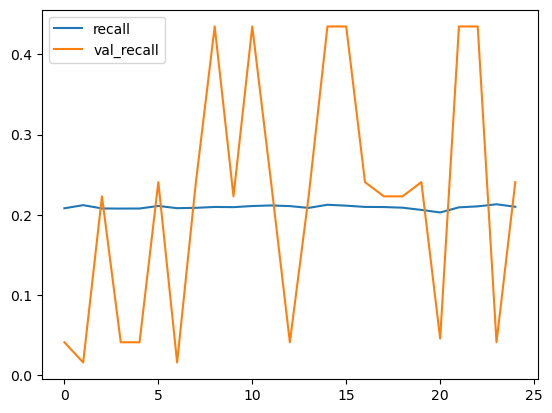

In [29]:
history_plots(s,'recall')

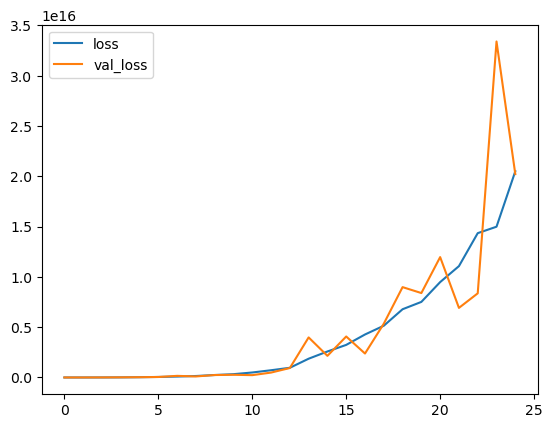

In [30]:
history_plots(s,'loss')

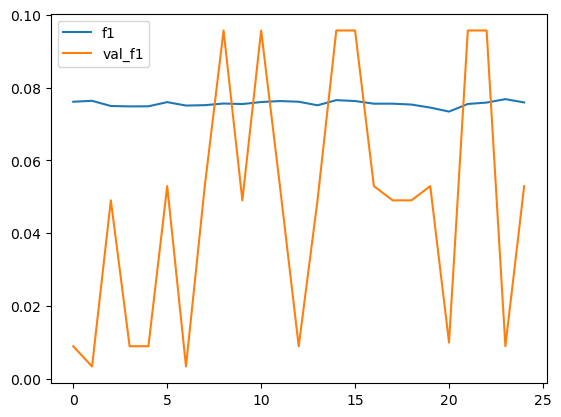

In [31]:
f1_derive(s,'precision','recall')

In [32]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model= Model(i,x)

In [33]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

f = model.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25


1117/1117 [==============================] - 67s 60ms/step - loss: 0.3651 - accuracy: 0.9728 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3644 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
1117/1117 [==============================] - 66s 59ms/step - loss: 0.3627 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3594 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.3611 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3632 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.3600 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3593 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
1117/1117 [=============

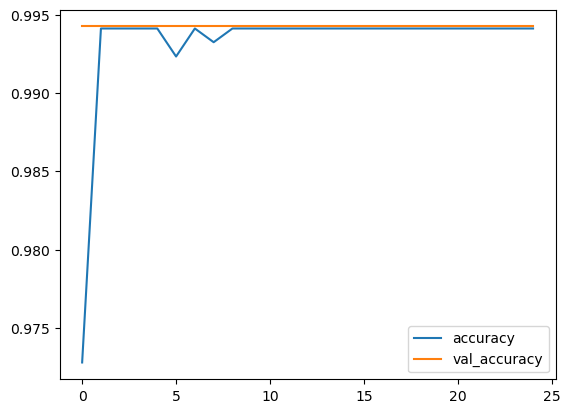

In [34]:
history_plots(f,'accuracy')

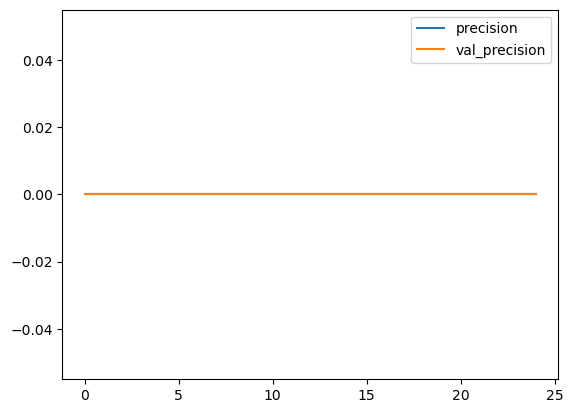

In [35]:
history_plots(f,'precision')

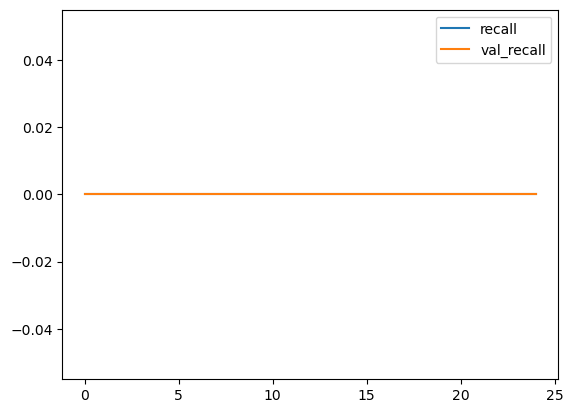

In [36]:
history_plots(f,'recall')

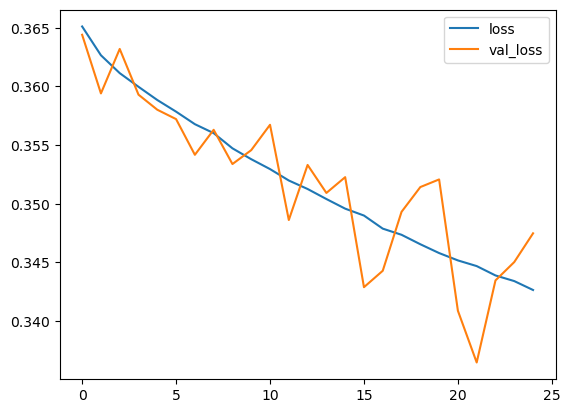

In [37]:
history_plots(f,'loss')

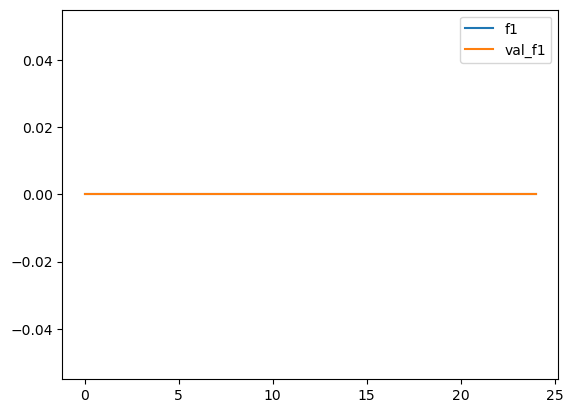

In [38]:
f1_derive(f,'precision','recall')

In [39]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model9= Model(i,x)

In [40]:
from tensorflow.keras.optimizers import Adam
model9.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.0001), metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

g = model9.fit(data_train, ytrain, epochs= 25, batch_size=500, validation_data=(data_valid, yvalid))

Epoch 1/25


224/224 [==============================] - 35s 152ms/step - loss: 0.3696 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3651 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3652 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3655 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3647 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3689 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3658 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3653 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
224/224 [===================

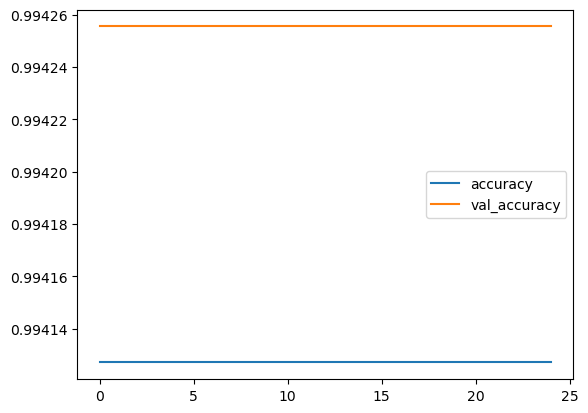

In [41]:
history_plots(g,'accuracy')

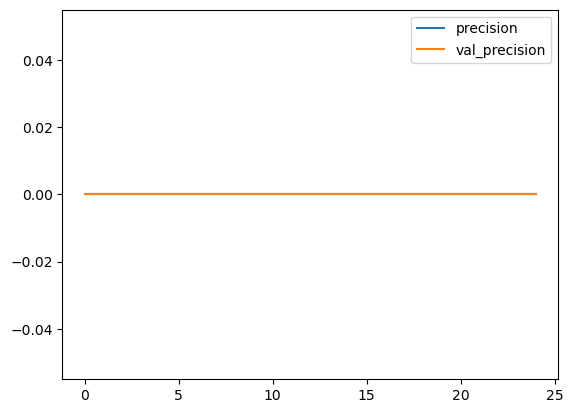

In [42]:
history_plots(g,'precision')

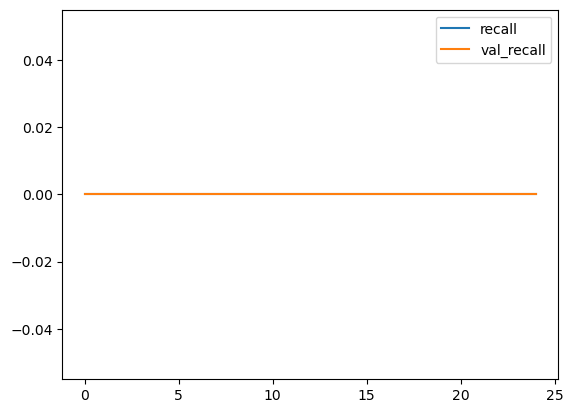

In [43]:
history_plots(g,'recall')

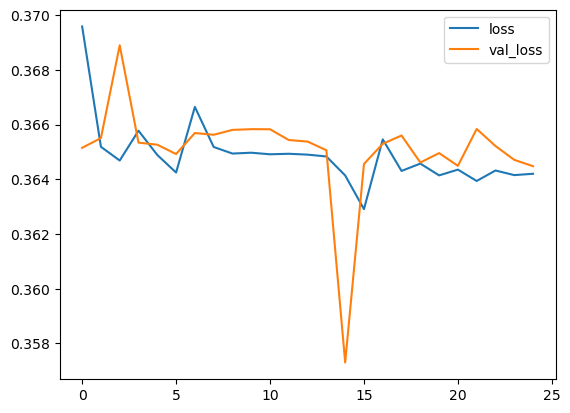

In [44]:
history_plots(g,'loss')

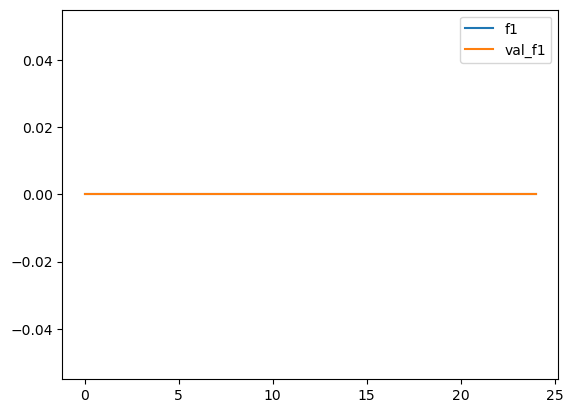

In [45]:
f1_derive(g,'precision','recall')

In [46]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model8= Model(i,x)

In [47]:
from tensorflow.keras.optimizers import Adam
model8.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.0005), metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

h = model8.fit(data_train, ytrain, epochs= 25, batch_size=500, validation_data=(data_valid, yvalid))

Epoch 1/25


224/224 [==============================] - 34s 151ms/step - loss: 0.3856 - accuracy: 0.1738 - precision: 0.0030 - recall: 1.2213e-04 - val_loss: 0.3895 - val_accuracy: 2.5067e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3854 - accuracy: 1.1638e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3833 - val_accuracy: 2.5067e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3842 - accuracy: 0.0536 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3836 - val_accuracy: 2.5067e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3841 - accuracy: 1.1638e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3849 - val_accuracy: 2.5067e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
224/224 

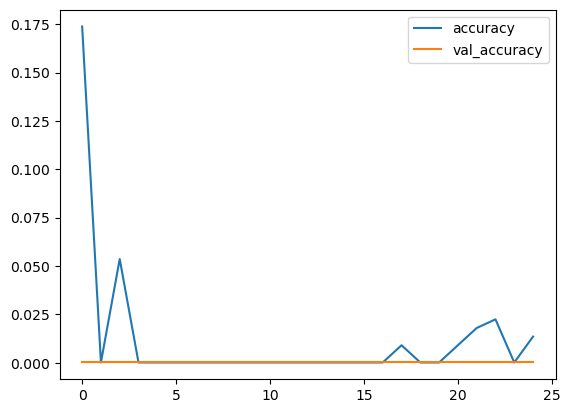

In [48]:
history_plots(h,'accuracy')

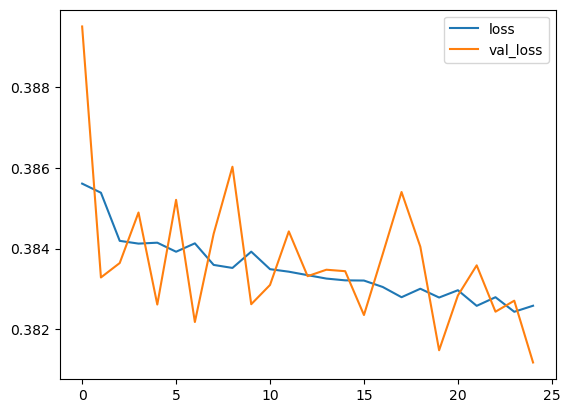

In [49]:
history_plots(h,'loss')

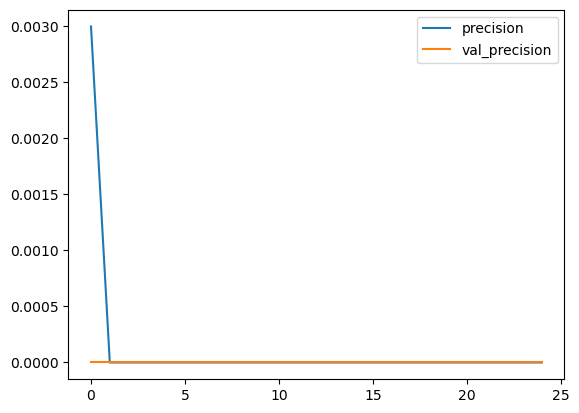

In [50]:
history_plots(h,'precision')

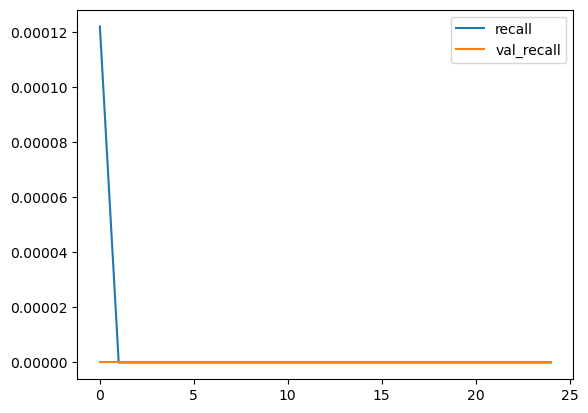

In [51]:
history_plots(h,'recall')

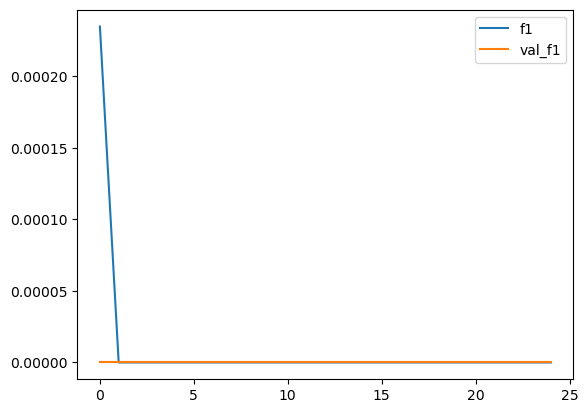

In [52]:
f1_derive(h)

In [53]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model7= Model(i,x)

In [54]:
from tensorflow.keras.optimizers import Adam
model7.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.00005), metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

e = model7.fit(data_train, ytrain, epochs= 25, batch_size=500, validation_data=(data_valid, yvalid))

Epoch 1/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3709 - accuracy: 0.7499 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3600 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3626 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3689 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3651 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3633 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3634 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3638 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
224/224 [========

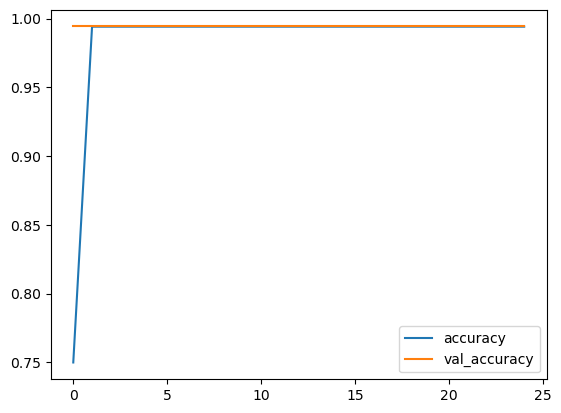

In [55]:
history_plots(e,'accuracy')

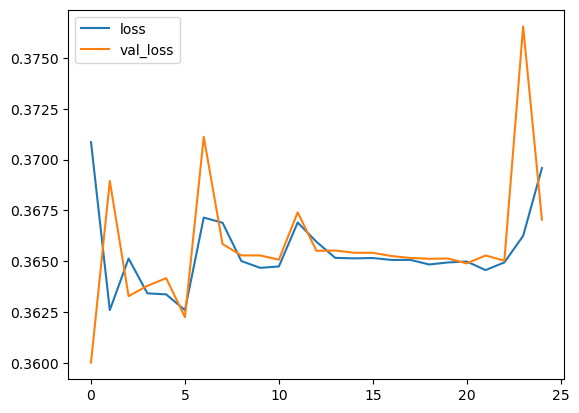

In [56]:
history_plots(e,'loss')

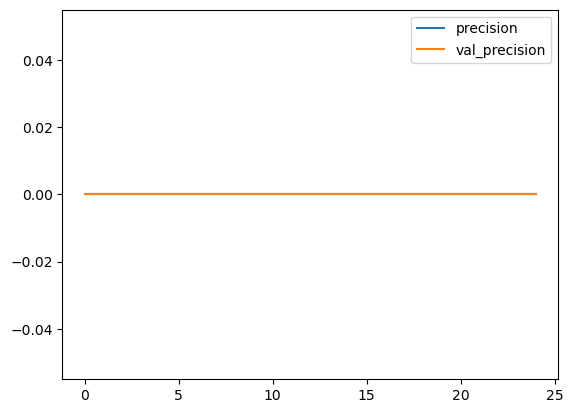

In [57]:
history_plots(e,'precision')

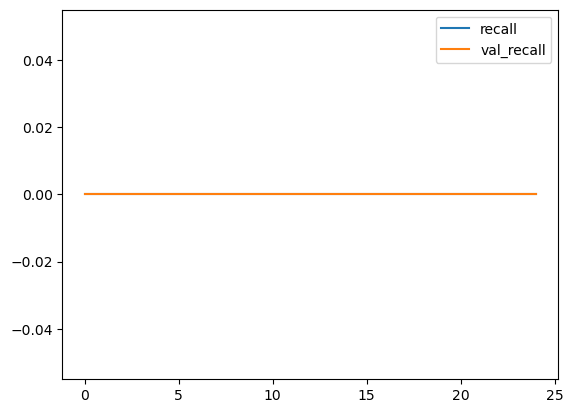

In [58]:
history_plots(e,'recall')

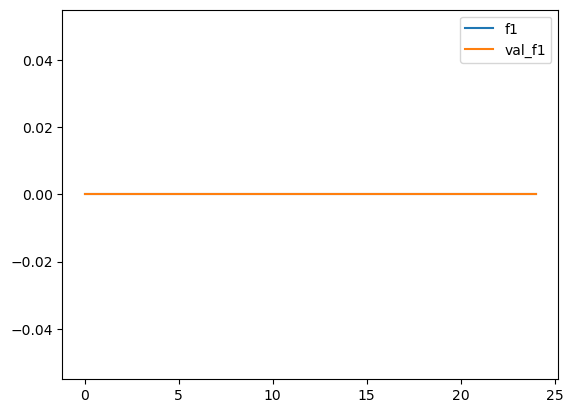

In [59]:
f1_derive(e)

In [70]:
model7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1250)]            0         
                                                                 
 embedding_6 (Embedding)     (None, 1250, 60)          9030480   
                                                                 
 conv1d_23 (Conv1D)          (None, 1248, 32)          5792      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 416, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 414, 64)           6208      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 138, 64)          0         
 g1D)                                                      

In [60]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model6= Model(i,x)

In [61]:

model6.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.00005), metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

k = model6.fit(data_train, ytrain, epochs= 25, batch_size=500, validation_data=(data_valid, yvalid))

Epoch 1/25


224/224 [==============================] - 34s 150ms/step - loss: 0.3761 - accuracy: 0.0021 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3753 - val_accuracy: 0.0021 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3749 - accuracy: 0.0021 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3752 - val_accuracy: 0.0021 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3731 - accuracy: 0.0021 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3719 - val_accuracy: 0.0021 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
224/224 [==============================] - 34s 150ms/step - loss: 0.3714 - accuracy: 0.0021 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3705 - val_accuracy: 0.0021 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
224/224 [===================

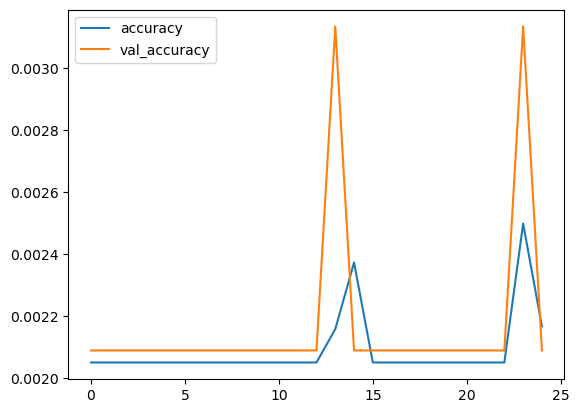

In [62]:
history_plots(k,'accuracy')

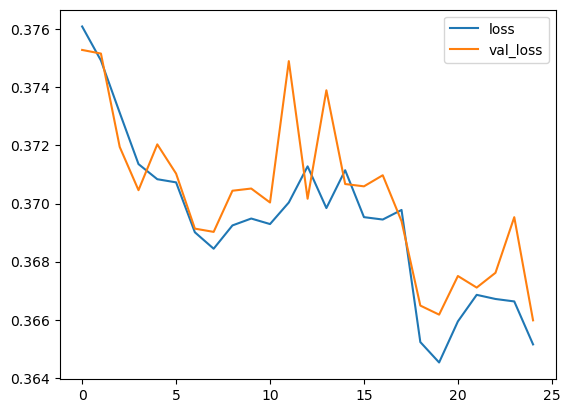

In [63]:
history_plots(k,'loss')

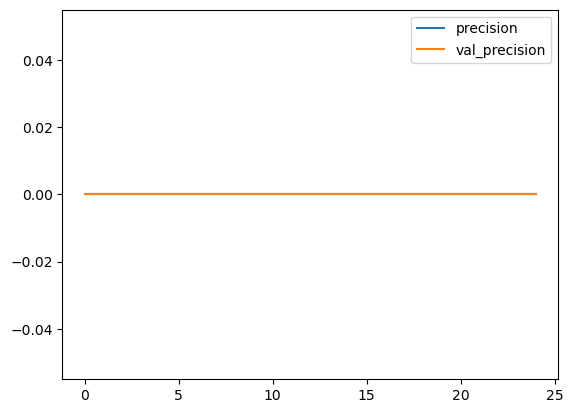

In [64]:
history_plots(k,'precision')

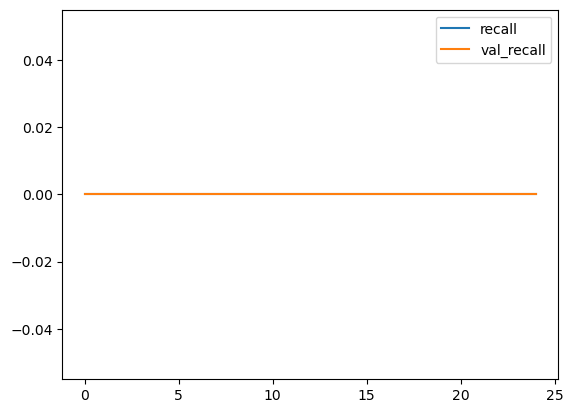

In [65]:
history_plots(k,'recall')

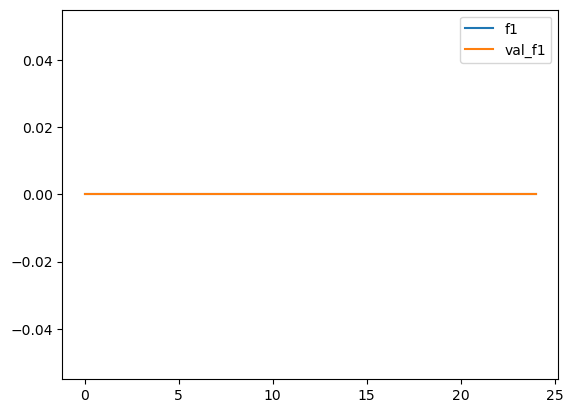

In [66]:
f1_derive(k)

In [71]:
from tensorflow.keras.callbacks import TensorBoard

In [73]:
filename= "CNN_EC_SIG_a1_e"
tb = TensorBoard(log_dir= "logs\\{}".format(filename))

Epoch 1/25
224/224 [==============================] - 34s 149ms/step - loss: 0.3392 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3393 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
224/224 [==============================] - 33s 148ms/step - loss: 0.3386 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3392 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
224/224 [==============================] - 33s 148ms/step - loss: 0.3390 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3399 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
224/224 [==============================] - 33s 148ms/step - loss: 0.3399 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3410 - val_accuracy: 0.9943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
224/224 [========

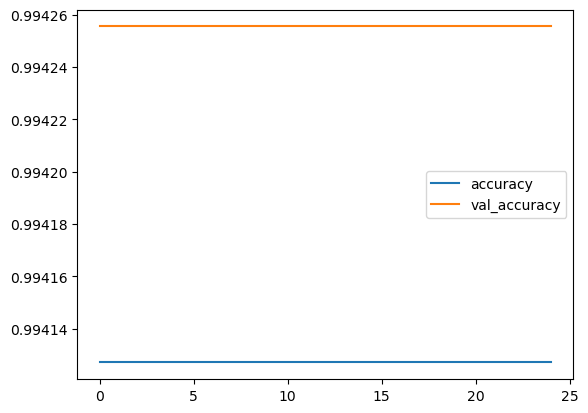

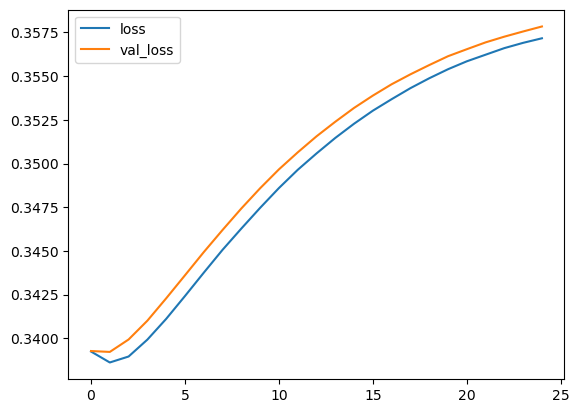

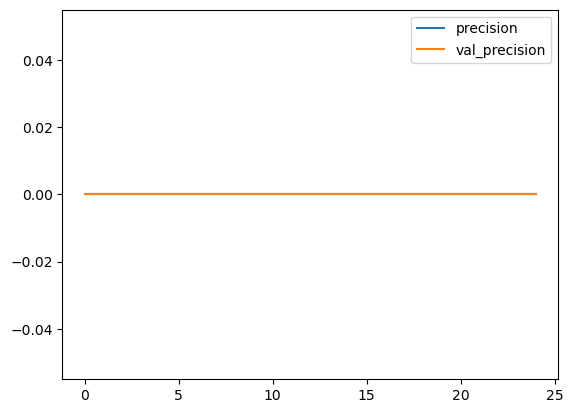

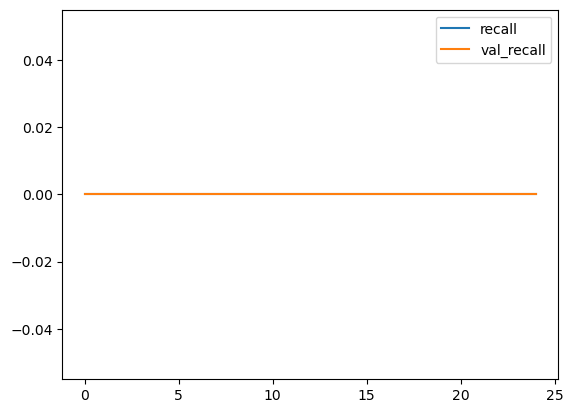

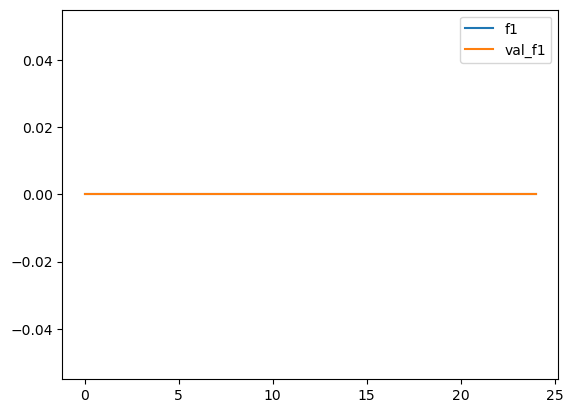

In [74]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

modela1= Model(i,x)
from tensorflow.keras.optimizers import SGD
modela1.compile(loss='categorical_crossentropy', optimizer= SGD(learning_rate=0.00005), metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

e = modela1.fit(data_train, ytrain, epochs= 25, batch_size=500, validation_data=(data_valid, yvalid), callbacks=[tb])
history_plots(e,'accuracy')
history_plots(e,'loss')
history_plots(e,'precision')
history_plots(e,'recall')
f1_derive(e)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [75]:
%pip install -U tensorboard-plugin-profile

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

                                              0.0/5.8 MB ? eta -:--:--
     --                                       0.3/5.8 MB 10.6 MB/s eta 0:00:01
     ------------------                       2.7/5.8 MB 34.7 MB/s eta 0:00:01
     ---------------------------------------  5.7/5.8 MB 45.9 MB/s eta 0:00:01
     ---------------------------------------- 5.8/5.8 MB 41.0 MB/s eta 0:00:00
